<a href="https://colab.research.google.com/github/Dmitrij188/-easy-/blob/main/model_inference_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import cv2
import numpy as np
import json

from torchvision.models import resnet18 as resnet18
from torchvision.models.segmentation import fcn_resnet50
from torchvision import transforms as T

import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

#**Подготовка данных**

In [235]:
IMAGE_PATH = '/content/cock.jpg'

OpenCV часто используется для обработки изображений, есть интерфейсы для Python и C++.

In [236]:
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV использует BGR формат представления цвета

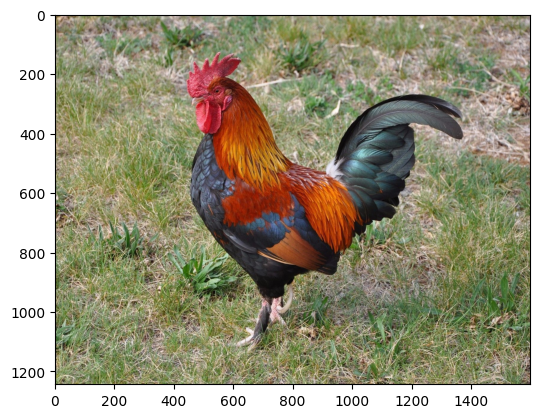

In [237]:
plt.imshow(image)

In [238]:
image

array([[[159, 133, 106],
        [138, 112,  85],
        [138, 114,  86],
        ...,
        [128, 122, 124],
        [135, 129, 133],
        [143, 138, 142]],

       [[131, 105,  78],
        [120,  94,  67],
        [126, 102,  74],
        ...,
        [138, 129, 132],
        [143, 137, 141],
        [150, 145, 149]],

       [[122,  96,  69],
        [114,  88,  61],
        [115,  91,  63],
        ...,
        [145, 136, 137],
        [150, 144, 146],
        [157, 151, 153]],

       ...,

       [[119, 138,  83],
        [121, 140,  85],
        [119, 138,  83],
        ...,
        [131, 116, 113],
        [176, 161, 158],
        [116, 101,  98]],

       [[117, 136,  81],
        [122, 141,  86],
        [135, 155, 102],
        ...,
        [101,  86,  83],
        [103,  88,  85],
        [ 68,  53,  50]],

       [[113, 132,  77],
        [120, 139,  84],
        [144, 164, 111],
        ...,
        [111,  96,  93],
        [ 68,  53,  50],
        [110,  95,  92]]

In [239]:
image.shape

(1244, 1600, 3)

In [240]:
h, w = image.shape[:2]
print(h, w)

1244 1600


ResNet-18, с которой будем работать далее,  была обучена на изображениях 224x224, поэтому предобразуем входное изображение к такому формату

In [241]:
image = image[:, (w - h) // 2 : (w - h) // 2 + h]  # center crop (если ширина >= высоты)
# image = image[(h - w) // 2 : (h - w) // 2 + w, :]  # center crop (если высота > ширины)

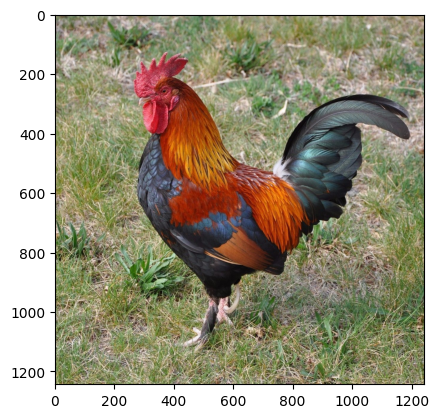

In [242]:
plt.imshow(image)

In [243]:
image.shape

(1244, 1244, 3)

In [244]:
image = cv2.resize(image, (224, 224))

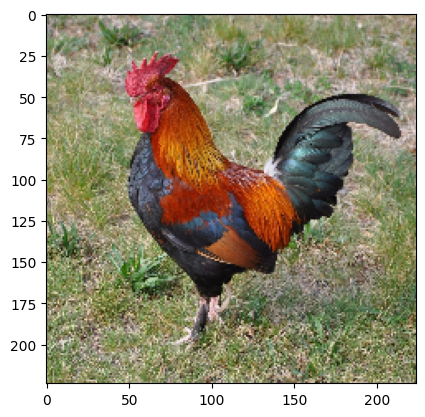

In [245]:
plt.imshow(image)

In [246]:
image.shape

(224, 224, 3)

Изначально изображение содержит величины интенсивности компонент RGB в диапазоне 0..255. Модели, как правило, принимают на вход нормализованные данные в виде чисел с плавающей точкой

In [247]:
image_tensor = torch.Tensor(image).float() / 255  # переводим в диапазон 0..1

In [248]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

image_tensor = (image_tensor - mean) / std  # делаем нормализацию

In [249]:
image_tensor

tensor([[[ 1.2214,  1.1506,  0.7576],
         [ 0.7419,  0.8529,  0.2348],
         [ 0.2624,  0.4853, -0.1312],
         ...,
         [ 0.8961,  0.8179,  0.5659],
         [ 0.8618,  0.8179,  0.6356],
         [ 0.4851,  0.5728, -0.0267]],

        [[ 0.8447,  0.9055,  0.5834],
         [ 0.1597,  0.3978,  0.0082],
         [-0.0629,  0.1176, -0.2358],
         ...,
         [ 0.6392,  0.4853,  0.1999],
         [ 0.7591,  0.6604,  0.4265],
         [ 0.9474,  0.9580,  0.5659]],

        [[ 0.0912,  0.2752, -0.1487],
         [-0.0116,  0.3627,  0.0082],
         [ 0.1083,  0.3627,  0.1302],
         ...,
         [ 0.9988,  0.8004,  0.5485],
         [ 0.6906,  0.5553,  0.3219],
         [ 0.8618,  0.8004,  0.5659]],

        ...,

        [[ 1.1187,  1.3782,  0.5659],
         [ 0.6563,  0.9405,  0.2522],
         [-0.3027,  0.2227, -0.7761],
         ...,
         [-0.2684,  0.1001, -0.5321],
         [ 0.2453,  0.1352, -0.2707],
         [-0.3369,  0.0126, -0.4101]],

        [[

In [250]:
image_tensor.shape

torch.Size([224, 224, 3])

В PyTorch принято, что канал цвета задан первой размерностью, а не последней

In [251]:
image_tensor = image_tensor.permute(2, 0, 1)

In [252]:
image_tensor.shape

torch.Size([3, 224, 224])

Модели обрабатывают данные в виде батчей - наборов нескольких изображений

In [253]:
batch = image_tensor.unsqueeze(0)

In [254]:
batch.shape

torch.Size([1, 3, 224, 224])

#**Классификация**

## Загрузка/сохранение модели

PyTorch предоставляет набор предобученных моделей, чтобы ими воспользоваться, достаточно указать pretrained=True

In [255]:
classifier = resnet18(pretrained=True).eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Веса хранятся в state_dict в виде словаря

In [256]:
sd = classifier.state_dict()
sd.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

Веса можно сохранить на диск. Как правило, такая операция производится в процессе обучения - checkpoints

In [257]:
torch.save(classifier.state_dict(), 'resnet18.pth')

Сохраненные таким образом веса можно загрузить в модель

In [258]:
sd = torch.load('resnet18.pth')
classifier.load_state_dict(sd)

<All keys matched successfully>

## Исследование архитектуры

### Текстовое представление и доступ к блокам

Архитектуру модели можно легко визуализировать в тектовом виде

In [259]:
classifier

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Доступ к отдельным блокам/слоям модели осуществляется по имени/индексу

In [260]:
classifier.layer1[1]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [261]:
classifier.layer1[1].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Этот сверточный слой содержит тензор весов, который при сохранении на диск имеет ключ layer1.1.conv1.weight

In [262]:
classifier.layer1[1].conv1.weight.shape

torch.Size([64, 64, 3, 3])

### Визуализация архитектуры

Для визуализации архитектуры модели можно экспортировать её в формате [ONNX](https://onnx.ai/) и визуализировать в [Netron](https://netron.app/)

In [263]:
!pip install onnx

In [264]:
!pip install onnxscript
torch.onnx.export(classifier, torch.randn(1, 3, 224, 224), 'resnet18.onnx')

[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"x"<FLOAT,[1,3,224,224]>
            ),
            outputs=(
                %"linear"<FLOAT,[1,1000]>
            ),
            initializers=(
                %"conv1.weight"<FLOAT,[64,3,7,7]>{Tensor(...)},
                %"layer1.0.conv1.weight"<FLOAT,[64,64,3,3]>{Tensor(...)},
                %"layer1.0.conv2.weight"<FLOAT,[64,64,3,3]>{Tensor(...)},
                %"layer1.1.conv1.weight"<FLOAT,[64,64,3,3]>{Tensor(...)},
                %"layer1.1.conv2.weight"<FLOAT,[64,64,3,3]>{Tensor(...)},
                %"layer2.0.conv1.weight"<FLOAT,[128,64,3,3]>{Tensor(...)},
                %"layer2.0.conv2.weight"<FLOAT,[128,128,3,3]>{Tensor(...)},
                

In [265]:
# !cp /content/resnet18.onnx /content/drive/MyDrive

Скачайте сохраненную в формате onnx модель, загрузите в [Netron](https://netron.app/) и экспортируйте изображение с визуализацией модели

## Предсказание модели

In [266]:
if torch.cuda.is_available():
    batch = batch.cuda()

if torch.cuda.is_available():
    classifier = classifier.cuda()

Произведем измерение скорости инференса. Обратите внимание на torch.cuda.synchronize(). CUDA операции выполняются асинхронно, то есть когда выполняется команда logits = classifier(batch), то процесс вычислений ставится в очередь, а не начинает выполняться незамедлительно. Кроме того, выход из этой операции не гарантирует завершение процесса вычислений. Однако, после синхронизации, все вычисления, поставленные в очередь до нее гарантированно завершаются.

In [267]:
%%timeit
with torch.no_grad():
    logits = classifier(batch)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

3 ms ± 467 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [268]:
with torch.no_grad():
    logits = classifier(batch)

In [269]:
logits.shape

torch.Size([1, 1000])

In [270]:
logits

tensor([[ 2.0119e+00,  3.3113e+00, -1.3592e+00, -2.1761e+00, -2.6489e+00,
         -4.4638e-01,  8.0325e-02,  1.7042e+01,  1.2810e+01,  3.5983e+00,
          1.3332e+00,  1.6160e+00,  2.6153e+00, -1.7322e+00,  1.3251e+00,
          5.9756e+00,  9.0846e-01,  6.9222e-01,  3.5516e+00, -1.1125e-01,
          2.2610e+00,  3.6250e+00,  9.1904e-01,  5.1509e+00,  8.7694e-03,
          1.1114e+00,  4.2281e-01,  1.0123e+00, -1.7603e+00,  1.1371e+00,
         -1.7030e+00, -2.3497e+00, -2.3326e+00, -1.5642e+00, -1.4094e+00,
          1.2286e+00,  1.7728e+00,  1.8105e+00,  3.1648e-01,  5.7714e+00,
          1.9664e+00,  2.8385e+00,  5.6298e+00,  5.1110e+00,  2.7158e+00,
          2.4023e+00,  1.3350e+00,  1.2287e-01,  4.6728e+00,  1.8733e+00,
          2.4741e+00,  2.3230e+00,  1.4358e+00,  1.5786e+00,  3.6262e+00,
         -6.9006e-01,  5.6152e+00,  4.4735e-01,  2.6164e+00, -8.5751e-01,
          2.6620e+00,  1.9095e+00,  3.4681e+00,  4.1449e+00, -1.6731e+00,
          1.5977e+00,  1.1830e+00,  6.

Для получения вероятностей классов применим softmax

In [271]:
probs = torch.softmax(logits, 1)

In [272]:
probs.shape

torch.Size([1, 1000])

In [273]:
probs

tensor([[2.9198e-07, 1.0707e-06, 1.0031e-08, 4.4316e-09, 2.7620e-09, 2.4989e-08,
         4.2315e-08, 9.8372e-01, 1.4288e-02, 1.4267e-06, 1.4812e-07, 1.9652e-07,
         5.3383e-07, 6.9073e-09, 1.4692e-07, 1.5374e-05, 9.6860e-08, 7.8025e-08,
         1.3616e-06, 3.4937e-08, 3.7458e-07, 1.4652e-06, 9.7890e-08, 6.7390e-06,
         3.9392e-08, 1.1866e-07, 5.9598e-08, 1.0746e-07, 6.7158e-09, 1.2174e-07,
         7.1119e-09, 3.7250e-09, 3.7893e-09, 8.1708e-09, 9.5388e-09, 1.3340e-07,
         2.2988e-07, 2.3873e-07, 5.3586e-08, 1.2534e-05, 2.7901e-07, 6.6734e-07,
         1.0880e-05, 6.4759e-06, 5.9029e-07, 4.3145e-07, 1.4839e-07, 4.4154e-08,
         4.1782e-06, 2.5421e-07, 4.6356e-07, 3.9853e-07, 1.6412e-07, 1.8931e-07,
         1.4670e-06, 1.9585e-08, 1.0721e-05, 6.1078e-08, 5.3443e-07, 1.6565e-08,
         5.5937e-07, 2.6357e-07, 1.2525e-06, 2.4643e-06, 7.3282e-09, 1.9296e-07,
         1.2746e-07, 7.5970e-08, 1.2439e-07, 5.4759e-08, 9.5981e-09, 2.2417e-07,
         7.9492e-09, 9.7969e

Выберем топ-5 классов, в которых уверена модель

In [274]:
topk = torch.topk(logits, 7)

In [275]:
topk

torch.return_types.topk(
values=tensor([[17.0420, 12.8101,  9.3835,  9.1022,  8.9554,  8.4925,  7.5046]],
       device='cuda:0'),
indices=tensor([[ 7,  8, 84, 80, 86, 91, 82]], device='cuda:0'))

In [276]:
with open('/imagenet1000_clsidx_to_labels.json', 'r') as f:
    imagenet1k_clsidx_to_labels = json.load(f)

In [277]:
for v in topk.indices[0]:
    print(imagenet1k_clsidx_to_labels[v])

cock
hen
peacock
black grouse
partridge
coucal
ruffed grouse


#**Семантическая сегментация**

In [278]:
segmentator = fcn_resnet50(pretrained=True).eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [279]:
if torch.cuda.is_available():
    segmentator = segmentator.cuda()

In [280]:
image = cv2.imread('/content/street3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

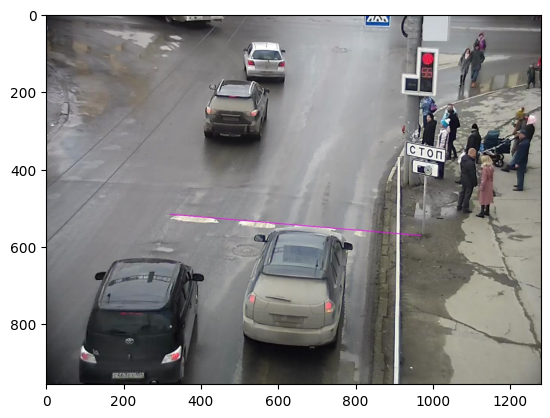

In [281]:
plt.imshow(image)

In [282]:
image_tensor = torch.Tensor(image).float() / 255

In [283]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

image_tensor = (image_tensor - mean) / std

In [284]:
image_tensor = image_tensor.permute(2, 0, 1)

In [285]:
batch = image_tensor.unsqueeze(0)

In [286]:
batch.shape

torch.Size([1, 3, 956, 1280])

In [287]:
if torch.cuda.is_available():
    batch = batch.cuda()

In [288]:
%%timeit
with torch.no_grad():
    logits = segmentator(batch)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

326 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [289]:
with torch.no_grad():
    logits = segmentator(batch)

In [290]:
logits

OrderedDict([('out',
              tensor([[[[ 6.1021,  6.1021,  6.1021,  ...,  5.5034,  5.5034,  5.5034],
                        [ 6.1021,  6.1021,  6.1021,  ...,  5.5034,  5.5034,  5.5034],
                        [ 6.1021,  6.1021,  6.1021,  ...,  5.5034,  5.5034,  5.5034],
                        ...,
                        [ 6.1483,  6.1483,  6.1483,  ...,  5.7246,  5.7246,  5.7246],
                        [ 6.1483,  6.1483,  6.1483,  ...,  5.7246,  5.7246,  5.7246],
                        [ 6.1483,  6.1483,  6.1483,  ...,  5.7246,  5.7246,  5.7246]],
              
                       [[ 0.1117,  0.1117,  0.1117,  ..., -1.0686, -1.0686, -1.0686],
                        [ 0.1117,  0.1117,  0.1117,  ..., -1.0686, -1.0686, -1.0686],
                        [ 0.1117,  0.1117,  0.1117,  ..., -1.0686, -1.0686, -1.0686],
                        ...,
                        [-0.4643, -0.4643, -0.4643,  ...,  0.7567,  0.7567,  0.7567],
                        [-0.4643, -0.4643, -0

In [291]:
print(logits['out'].shape)
print(logits['aux'].shape)

torch.Size([1, 21, 956, 1280])
torch.Size([1, 21, 956, 1280])


In [292]:
probs = torch.softmax(logits['out'][0], 0)

In [293]:
with open('/coco_clsidx_to_labels.json', 'r') as f:
    coco_clsidx_to_labels = json.load(f)

In [294]:
probs.cpu().shape

torch.Size([21, 956, 1280])

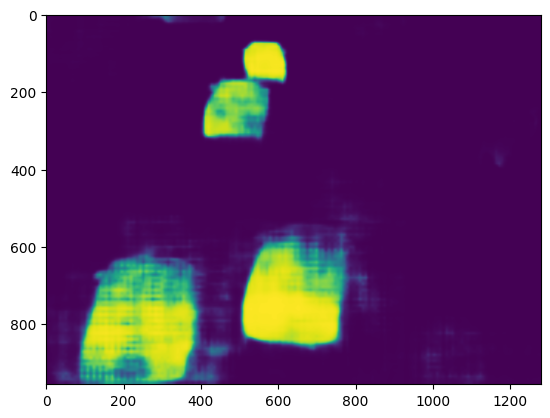

In [295]:
plt.imshow(probs.cpu()[coco_clsidx_to_labels.index('car')])

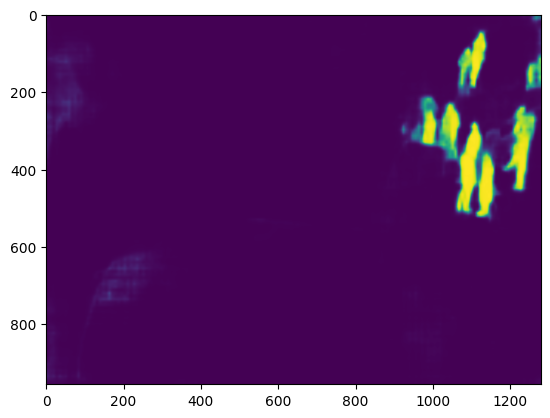

In [296]:
plt.imshow(probs.cpu()[coco_clsidx_to_labels.index('person')])

In [297]:
classes = probs.argmax(dim=0) * (probs.max(dim=0).values > 0.5)

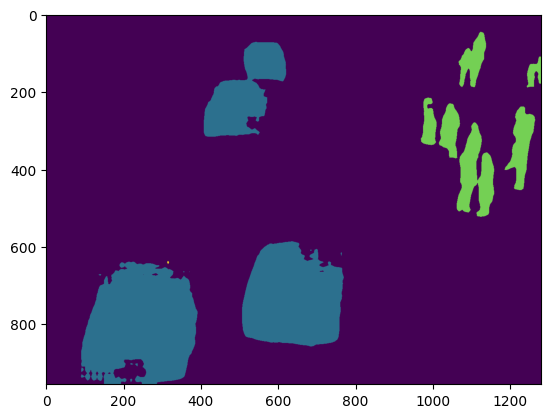

In [298]:
plt.imshow(classes.cpu())

In [299]:
rgb_pallete = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 255],  # bicycle
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [255, 0, 0],  # car
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 255, 0],  # person
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

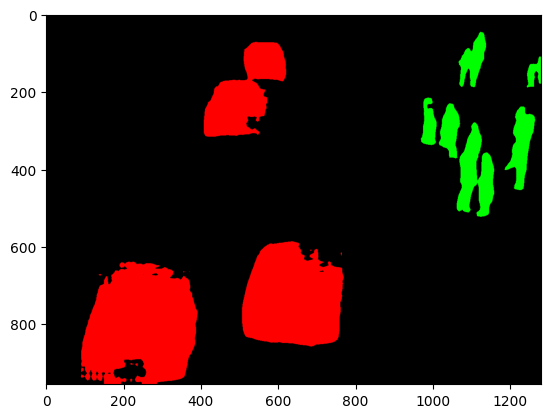

In [300]:
plt.imshow(rgb_pallete[classes.cpu()])